In [1]:
import netCDF4 as nc
from matplotlib import pyplot as plt
import numpy as np
import glob
import pickle
from salishsea_tools import evaltools as et
import datetime as dt
import os
import re
import pandas as pd
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=mesh.variables['tmask'][0,:,:,:]
    e1t=np.expand_dims(mesh.variables['e1t'][:,:,:],1)
    e2t=np.expand_dims(mesh.variables['e2t'][:,:,:],1)
SOGtmaskPath='/ocean/eolson/MEOPAR/northernNO3PaperCalcs/save/SOGtmask.pkl'
(tmaskSOG,_,_,_,_)=pickle.load(open(SOGtmaskPath,'rb'))

In [5]:
PATH= '/data/sallen/results/MEOPAR/fluxes/'
flistP=et.index_model_files_flex(PATH,'dian_T',dt.datetime(2013,1,1),dt.datetime(2013,2,15))

In [6]:
flistP

,paths,t_0,t_n
0,/data/sallen/results/MEOPAR/fluxes/01jan13/Sal...,2013-01-01,2013-01-06
1,/data/sallen/results/MEOPAR/fluxes/06jan13/Sal...,2013-01-06,2013-01-11
2,/data/sallen/results/MEOPAR/fluxes/11jan13/Sal...,2013-01-11,2013-01-16
3,/data/sallen/results/MEOPAR/fluxes/16jan13/Sal...,2013-01-16,2013-01-21
4,/data/sallen/results/MEOPAR/fluxes/21jan13/Sal...,2013-01-21,2013-01-26
5,/data/sallen/results/MEOPAR/fluxes/26jan13/Sal...,2013-01-26,2013-02-01
6,/data/sallen/results/MEOPAR/fluxes/01feb13/Sal...,2013-02-01,2013-02-06
7,/data/sallen/results/MEOPAR/fluxes/06feb13/Sal...,2013-02-06,2013-02-11
8,/data/sallen/results/MEOPAR/fluxes/11feb13/Sal...,2013-02-11,2013-02-16


In [7]:
no3sum=list()
physSum=list()
bioSum=list()
rivSum=list()
nitrSum=list()
PPSum=list()
afiltSum=list()
for ifl in flistP['paths']:
    with nc.Dataset(ifl) as fP:
        no3sum.append(np.sum(np.sum(np.sum(tmaskSOG*e1t*e2t*fP.variables['NO3_E3T'][:,:,:,:],3),2),1))
        physSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['PHYSTRNO3'][:,:,:,:],3),2),1))
        bioSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['BIOTRNO3'][:,:,:,:],3),2),1))
        rivSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['RIVNO3'][:,:,:,:],3),2),1)*40)
        nitrSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['NITR'][:,:,:,:],3),2),1))
        PPSum.append(np.sum(np.sum(np.sum(tmaskSOG*(fP.variables['PPDIATNO3V'][:,:,:,:]+\
                                                     fP.variables['PPPHYNO3V'][:,:,:,:]+\
                                                     fP.variables['PPMRUBNO3V'][:,:,:,:]),3),2),1))
        afiltSum.append(np.sum(np.sum(np.sum(tmaskSOG*fP.variables['AFILTNO3'][:,:,:,:],3),2),1))
no3sum=np.concatenate(no3sum)
physSum=np.concatenate(physSum)
bioSum=np.concatenate(bioSum)
rivSum=np.concatenate(rivSum)
nitrSum=np.concatenate(nitrSum)
PPSum=np.concatenate(PPSum)
afiltSum=np.concatenate(afiltSum)

In [8]:
no3diff=(no3sum[1:]-no3sum[:-1])/(24*3600)

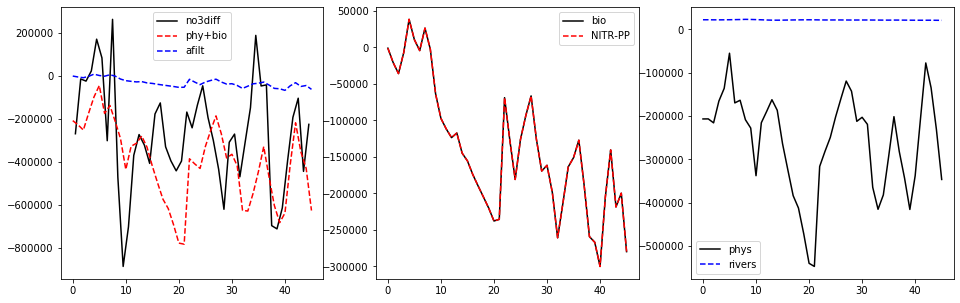

In [9]:
fig,ax=plt.subplots(1,3,figsize=(16,5))
ax[0].plot(np.arange(0.5,len(no3diff),1),no3diff,'k-',label='no3diff')
ax[0].plot(range(0,len(physSum)),physSum+bioSum,'r--',label='phy+bio')
ax[0].plot(range(0,len(afiltSum)),afiltSum,'b--',label='afilt')
ax[0].legend()
ax[1].plot(range(0,len(bioSum)),bioSum,'k-',label='bio')
ax[1].plot(range(0,len(nitrSum)),nitrSum-PPSum,'r--',label='NITR-PP')
ax[1].legend()
ax[2].plot(range(0,len(physSum)),physSum,'k-',label='phys')
ax[2].plot(range(0,len(rivSum)),rivSum,'b--',label='rivers')
ax[2].legend()

In [11]:
flistM=et.index_model_files_flex(PATH,'Malaspina_U',dt.datetime(2013,1,1),dt.datetime(2013,2,15))
malUA=list()
malUD=list()
for ifl in flistM['paths']:
    with nc.Dataset(ifl) as f:
        malUA.append(np.sum(np.sum(f.variables['NO3_UT'][:,:,:,0],2),1))
        malUD.append(np.sum(np.sum(f.variables['ULDFNO3T'][:,:,:,0],2),1))
malUA=np.concatenate(malUA)
malUD=np.concatenate(malUD)

In [31]:
def catV(ftype):
    flist=et.index_model_files_flex(PATH,ftype,dt.datetime(2013,1,1),dt.datetime(2013,2,15))
    VA=list()
    VD=list()
    for ifl in flist['paths']:
        with nc.Dataset(ifl) as f:
            VA.append(np.sum(np.sum(f.variables['NO3_VT'][:,:,0,:],2),1))
            VD.append(np.sum(np.sum(f.variables['VLDFNO3T'][:,:,0,:],2),1))
    VA=np.concatenate(VA)
    VD=np.concatenate(VD)
    return VA,VD

In [32]:
harVA,harVD=catV('Haro_V')

In [33]:
sjcVA,sjcVD=catV('SJC_V')

In [34]:
rosVA,rosVD=catV('Rosario_V')

In [35]:
sutVA,sutVD=catV('Sutil_V')

In [36]:
disVA,disVD=catV('Discovery_V')

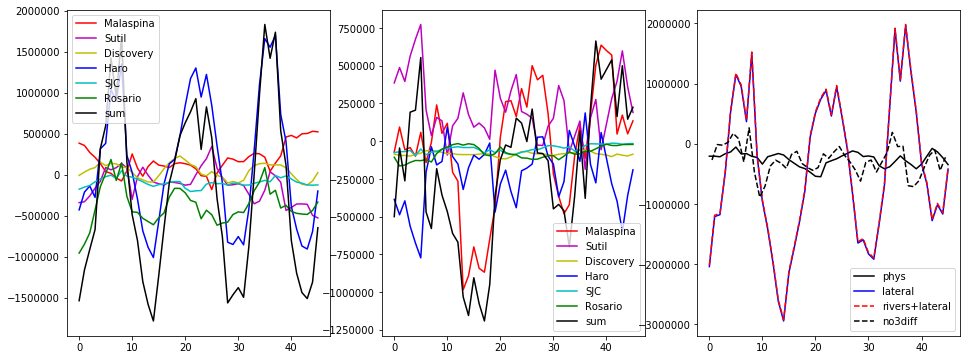

In [38]:
fig,ax=plt.subplots(1,3,figsize=(16,6))
ax[0].plot(range(0,len(malUA)),-1*malUA,'r-',label='Malaspina')
ax[0].plot(range(0,len(sutVA)),-1*sutVA,'m-',label='Sutil')
ax[0].plot(range(0,len(disVA)),-1*disVA,'y-',label='Discovery')
ax[0].plot(range(0,len(harVA)),harVA,'b-',label='Haro')
ax[0].plot(range(0,len(sjcVA)),sjcVA,'c-',label='SJC')
ax[0].plot(range(0,len(rosVA)),rosVA,'g-',label='Rosario')
ax[0].plot(range(0,len(harVA)),harVA+sjcVA+rosVA-disVA-sutVA-malUA,'k-',label='sum')
ax[0].legend()
ax[1].plot(range(0,len(malUD)),-1*malUD,'r-',label='Malaspina')
ax[1].plot(range(0,len(sutVD)),-1*sutVD,'m-',label='Sutil')
ax[1].plot(range(0,len(disVD)),-1*disVD,'y-',label='Discovery')
ax[1].plot(range(0,len(sutVD)),sutVD,'b-',label='Haro')
ax[1].plot(range(0,len(sjcVD)),sjcVD,'c-',label='SJC')
ax[1].plot(range(0,len(rosVD)),rosVD,'g-',label='Rosario')
ax[1].plot(range(0,len(harVD)),harVD+sjcVD+rosVD-disVD-sutVD-malUD,'k-',label='sum')
ax[1].legend()
ax[2].plot(range(0,len(physSum)),physSum,'k-',label='phys')
ax[2].plot(range(0,len(harVA)),harVA+sjcVA+rosVA-disVA-sutVA-malUA+harVD+sjcVD+rosVD-disVD-sutVD-malUD,'b-',label='lateral')
ax[2].plot(range(0,len(harVA)),harVA+sjcVA+rosVA-disVA-sutVA-malUA+harVD+sjcVD+rosVD-disVD-sutVD-malUD+rivSum,'r--',label='rivers+lateral')
ax[2].plot(np.arange(0.5,len(no3diff),1),no3diff,'k--',label='no3diff')
ax[2].legend()